<a href="https://colab.research.google.com/github/snpushpi/6.804-Computational-Cognitive-Science/blob/master/Plot_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import math
import scipy.stats

In [2]:
state_set = {'A','B','C','D'}
mu_dict = {'A':.2,'B':.4,'C':.6,'D':.8}
sigma = 0.1

In [3]:
def weight_based_sampling(S): #[[state,weight]]
    states=[e[0] for e in S] 
    weights = [e[1] for e in S]
    state =  np.random.choice(states,p=weights) #states [[][]]
    weight = None
    for elt in S:
        if elt[0]==state:
            weight = elt[1]
    return state,weight

In [4]:
def weight_calculate(S):
    weight_dict = {'A':0,'B':0,'C':0,'D':0}
    for state,weight in S:
        weight_dict[state]+=weight
    return weight_dict

PF class goes here

In [5]:
class Particle_Filter():

    def __init__(self,particle_num,r):
        self.n = particle_num
        self.S = [[random.choice(tuple(state_set)),1/particle_num] for i in range(particle_num)]
        self.r = r
        self.prediction = None
        self.similarity = None
        self.weight_dict = None

    def update(self,observation, human_observation):
        '''self.S gets updated at each trial.'''
        S_new = [] 
        eta = 0 
        for i in range(self.n):
            state,weight = weight_based_sampling(self.S) #a particle 
            x1 = random.uniform(0,1) 
            if x1<self.r: #change state - (1-e**(-r*k)) =>
                new_set = state_set-{state}
                state= random.choice(tuple(new_set))
            new_weight = scipy.stats.norm(mu_dict[state],sigma).pdf(observation)
            eta+= new_weight
            S_new.append([state,new_weight])
        S_new = [[elt[0],elt[1]/eta] for elt in S_new]
        self.weight_dict = weight_calculate(S_new)
        self.prediction = max(self.weight_dict, key=self.weight_dict.get)
        self.similarity = self.weight_dict[human_observation]
        self.S = S_new


Normal PF run goes here 

In [6]:
def normal_PF_run(particle_number,observation_list,human_inference_list,r):
    PF = Particle_Filter(particle_number,r)
    model_inference = []
    for i in range(len(observation_list)):
        PF.update(observation_list[i],human_inference_list[i])
        model_inference.append([PF.prediction, PF.similarity])
    return model_inference

Nested PF helper function:

In [7]:
def most_probable_state_prediction(particle_filter_list):
    '''Each element in this list is a particle filter itself. This function returns teh most weighed state of all the particle 
    filters. Recall that particle filters themselves are weighed too, so we keep that in mind in the computation too
    '''
    #weight check 
    check_weight = 0
    for particle_filter, weight in particle_filter_list:
        check_weight+=weight  
    weight_dictionary = {'A':0,'B':0,'C':0,'D':0}
    for particle_filter,particle_filter_weight in particle_filter_list:
        for elt in weight_dictionary:
            weight_dictionary[elt]+= particle_filter.weight_dict[elt]*particle_filter_weight
    max_prob_state = max(weight_dictionary, key=weight_dictionary.get)
    return max_prob_state, weight_dictionary 

Nested PF run goes here 

In [8]:
def nested_PF_run(particle_filter_num, observation_list, human_prediction_list, particle_num, r):
    #main challenge - how to weight the particle filters themselves?
    #working on the base that the particle filters whoch are more consistent with the human rpediction should be weghed high
    #The way I do it is the following - 
    #After any trial, the weight of a particle filter is the probability with which it is generating the observant's prediction 
    particle_filter_list = [[Particle_Filter(particle_num,r),1/particle_filter_num] for i in range(particle_filter_num)]
    model_prediction = []
    for i in range(len(observation_list)):
        eta = 0
        H_new = []
        particle_filter_keeper = []
        #model_prediction.append(most_probable_state_prediction(particle_filter_list))
        for particle_filter,weight in particle_filter_list:
            particle_filter.update(observation_list[i],human_prediction_list[i])
            particle_filter_keeper.append([particle_filter,weight])
            weight = particle_filter.weight_dict[human_prediction_list[i]] 
            H_new.append([particle_filter,weight])
            eta+=weight
        most_prob_state, weight_dict = most_probable_state_prediction(particle_filter_keeper)
        model_prediction.append([most_prob_state,weight_dict[human_prediction_list[i]]])
        H_new = [[elt[0],elt[1]/eta] for elt in H_new]
        #At this point, we will get the model prediction, which we are actually getting from the weighed particle filters,
        #In other words, each particle filter is consistent with human prediction and the more it is consistent, the higherweight it gets
        #Now to get the model prediction as a whole, or the prediction from researcher filter would be the weighed prediction from all partcile filters
        # and the state getting highest weight this way is the researcher's prediction. This role is being done by the most_probable_state_prediction
        #H_New = [[particle_filter, weight]]
        particle_filter_index_list = [[i,H_new[i][1]] for i in range(particle_filter_num)]
        new_list = []
        weight_sum = 0
        for j in range(particle_filter_num):
            index, weight = weight_based_sampling(particle_filter_index_list)
            weight_sum+= weight
            new_list.append([H_new[index][0],weight])
        particle_filter_list =  [[elt[0],elt[1]/weight_sum] for elt in new_list]
    return model_prediction

Normal PF similarity measure here -

In [9]:
def normal_PF_accuracy_and_similarity(human_inference_list, particle_number, observation_list, actual_list, r):
    '''This function returns both the task accuracy and human similarity measure of the normal
    particle filter model'''
    model_inference_list = normal_PF_run(particle_number,observation_list,human_inference_list,r)
    human_similarity_measure = 0
    task_counter = 0
    for i in range(len(observation_list)):
        human_similarity_measure+=model_inference_list[i][1]
        if actual_list[i]==model_inference_list[i][0]:
            task_counter+=1
    return human_similarity_measure/len(observation_list),task_counter/len(observation_list)


Nested PF similarity measure here-

In [10]:
def nested_PF_accuracy_and_similarity(human_inference_list, particle_number, particle_filter_num, observation_list, actual_list, r):
    '''This function returns both the task accuracy and human similarity measure of the normal
    particle filter model'''
    model_inference_list = nested_PF_run(particle_filter_num, observation_list, human_inference_list, particle_number, r)
    human_similarity_measure = 0
    task_counter = 0
    for i in range(len(observation_list)):
        human_similarity_measure+=model_inference_list[i][1]
        if actual_list[i]==model_inference_list[i][0]:
            task_counter+=1
    return human_similarity_measure/len(observation_list),task_counter/len(observation_list)


Synthetic data generation

In [11]:
def synthetic_data_generate(observation_list):
    inference_list = []
    for observation in observation_list:
        best_state = 'A'
        for state in state_set:
            if scipy.stats.norm(mu_dict[state],sigma).pdf(observation)>scipy.stats.norm(mu_dict[best_state],sigma).pdf(observation):
                best_state = state
        inference_list.append(best_state)
    return inference_list

Observation List generation

In [12]:
def data_generate(alpha,T):
    '''Goal is generate T observations with state changing probability alpha.
    Step 1: Set Z_0 as a random sample from state list.
    Step 2: Repeat the following for T trials -
          i) Z_i = Z_i-1
          ii)Sample x randomly from [0,1]
          iii) If x<alpha replace Z_i with random sample {A,B,C,D}/Z_i-1
          iv)Sample stimulus y_i form a normal distribution with std sigma and mu_zi
    '''
    observation_list = []
    Z = [None]*(T+1)
    Z[0] = random.choice(tuple(state_set))
    for i in range(1,T+1):
        Z[i]=Z[i-1]
        x = random.uniform(0,1)
        if x<alpha:
            new_set = state_set-{Z[i-1]}
            Z[i]= random.choice(tuple(new_set))
        observation_list.append(random.gauss(mu_dict[Z[i]],sigma))        
    return observation_list,Z[1:]

For each of the 103 synthetic subjects and each of the alphas, we run both normal PF and nested PF and calculate the similarity measure in ecah case

In [16]:
alpha_list = [0.08,0.16,0.32]
related_r = {0.08:0.1,0.16:.18,0.32:0.35}
T = 40
result_dict = {0.08:{'normal_PF':[],'nested_PF':[]},0.16:{'normal_PF':[],'nested_PF':[]},0.32:{'normal_PF':[],'nested_PF':[]}}
for alpha in alpha_list:
    for i in range(40):
        observation_list,actual_list = data_generate(alpha,T)
        result_dict[alpha]['normal_PF'].append(0)
        result_dict[alpha]['nested_PF'].append(0)
        synthetic_inference_list = synthetic_data_generate(observation_list)
        result_dict[alpha]['normal_PF'][i],_= normal_PF_accuracy_and_similarity(synthetic_inference_list, 1000, observation_list, actual_list, related_r[alpha])
        result_dict[alpha]['nested_PF'][i],_= nested_PF_accuracy_and_similarity(synthetic_inference_list, 10, 100, observation_list, actual_list, related_r[alpha])
        print(result_dict[alpha]['normal_PF'],result_dict[alpha]['nested_PF'])



[0.7292343362617209] [0.8705356209302648]
[0.7292343362617209, 0.7377205000481728] [0.8705356209302648, 0.9106106384293013]
[0.7292343362617209, 0.7377205000481728, 0.7311538513625695] [0.8705356209302648, 0.9106106384293013, 0.9243356293136096]
[0.7292343362617209, 0.7377205000481728, 0.7311538513625695, 0.8487042382614185] [0.8705356209302648, 0.9106106384293013, 0.9243356293136096, 0.9448708018195789]
[0.7292343362617209, 0.7377205000481728, 0.7311538513625695, 0.8487042382614185, 0.5878338125483934] [0.8705356209302648, 0.9106106384293013, 0.9243356293136096, 0.9448708018195789, 0.9288037366400029]
[0.7292343362617209, 0.7377205000481728, 0.7311538513625695, 0.8487042382614185, 0.5878338125483934, 0.7884198780166131] [0.8705356209302648, 0.9106106384293013, 0.9243356293136096, 0.9448708018195789, 0.9288037366400029, 0.9284390309160189]
[0.7292343362617209, 0.7377205000481728, 0.7311538513625695, 0.8487042382614185, 0.5878338125483934, 0.7884198780166131, 0.78421452245338] [0.870535

In [17]:
result_dict

{0.08: {'nested_PF': [0.8705356209302648,
   0.9106106384293013,
   0.9243356293136096,
   0.9448708018195789,
   0.9288037366400029,
   0.9284390309160189,
   0.9496712617139778,
   0.9104318078694881,
   0.8965666442880051,
   0.9040401041303209,
   0.9433395718187398,
   0.9355739918557019,
   0.931464234773431,
   0.9362635518955477,
   0.9367204055638068,
   0.9022739218022288,
   0.9228713097128416,
   0.8972479586775931,
   0.8960980673433788,
   0.9427092679646145,
   0.9325287636937171,
   0.9305808332127123,
   0.9171950390620631,
   0.9050325806731389,
   0.9260181626218997,
   0.9281855662558118,
   0.9285211849488355,
   0.8979493280910443,
   0.9488806191273979,
   0.9059613976726929,
   0.9219145790712963,
   0.885490535256114,
   0.9239025868818566,
   0.9419075528442592,
   0.9155850073779043,
   0.974606127476334,
   0.9367046205068881,
   0.9501613132869491,
   0.901772161656879,
   0.9118741630641992],
  'normal_PF': [0.7292343362617209,
   0.7377205000481728,
   0.

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

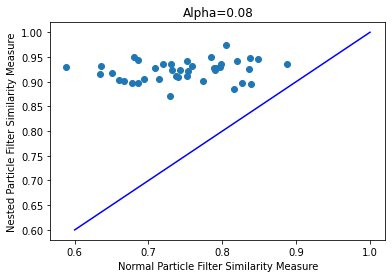

In [31]:
fig = plt.figure()
plt.clf()
x_list = result_dict[0.08]['normal_PF']
y_list = result_dict[0.08]['nested_PF']
plt.xlabel('Normal Particle Filter Similarity Measure')
plt.ylabel('Nested Particle Filter Similarity Measure')
plt.title("Alpha=0.08")
plt.scatter(x_list, y_list)
x = np.arange(0.6,1.01,0.01)
y = x
plt.plot(x, y, "b")


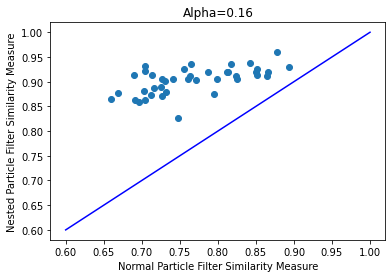

In [36]:
fig = plt.figure()
plt.clf()
x_list = result_dict[0.16]['normal_PF']
y_list = result_dict[0.16]['nested_PF']
plt.xlabel('Normal Particle Filter Similarity Measure')
plt.ylabel('Nested Particle Filter Similarity Measure')
plt.title("Alpha=0.16")
plt.scatter(x_list, y_list)
x = np.arange(0.6,1.01,0.01)
y = x
plt.plot(x, y, "b")


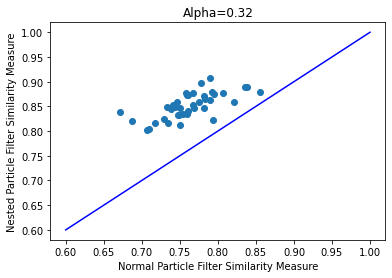

In [35]:
fig = plt.figure()
plt.clf()
x_list = result_dict[0.32]['normal_PF']
y_list = result_dict[0.32]['nested_PF']
plt.xlabel('Normal Particle Filter Similarity Measure')
plt.ylabel('Nested Particle Filter Similarity Measure')
plt.title("Alpha=0.32")
plt.scatter(x_list, y_list)
x = np.arange(0.6,1.01,0.01)
y = x
plt.plot(x, y, "b")
